In [1]:
# import packages needed
import os
import json
import seaborn as sns
import numpy as np
import pandas as pd
import geopandas as gpd
import re
import string
import unicodedata
from bs4 import BeautifulSoup
from wordcloud import WordCloud, STOPWORDS
from matplotlib import figure
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import mapclassify

# 1. Load the data

## 1.1 London Borough Map

<AxesSubplot:>

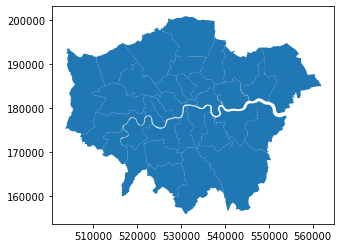

In [2]:
boros = gpd.read_file('https://github.com/HaofuW/CASA0013_Mic/blob/main/Assessment3/Code/Boroughs.gpkg?raw=true')
boros.plot()

## 1.2 Inside Airbnb

In [3]:
cols = ['id','name','price','neighbourhood_cleansed','latitude','longitude','property_type','room_type']
url_airbnb = 'https://github.com/HaofuW/CASA0013_Mic/blob/main/Assessment3/Code/listings.csv?raw=true'
df_airbnb = pd.read_csv(url_airbnb, usecols=cols)

df_airbnb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67903 entries, 0 to 67902
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      67903 non-null  int64  
 1   name                    67879 non-null  object 
 2   neighbourhood_cleansed  67903 non-null  object 
 3   latitude                67903 non-null  float64
 4   longitude               67903 non-null  float64
 5   property_type           67903 non-null  object 
 6   room_type               67903 non-null  object 
 7   price                   67903 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 4.1+ MB


### Data Cleaning

In [4]:
# clean the data
df_airbnb['price'] = df_airbnb.price.str.replace('$','').str.replace(',','').astype(float)
df_airbnb.drop(df_airbnb[((df_airbnb.latitude.isna())|(df_airbnb.longitude.isna()))].index, axis=0, inplace=True)
df_airbnb.drop(df_airbnb[((df_airbnb.latitude < 40)|(df_airbnb.longitude > 1))].index, axis=0, inplace=True)

df_airbnb.info

<ipython-input-4-38418f533085>:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df_airbnb['price'] = df_airbnb.price.str.replace('$','').str.replace(',','').astype(float)


<bound method DataFrame.info of              id                                               name  \
0         13913                Holiday London DB Room Let-on going   
1         15400                Bright Chelsea  Apartment. Chelsea!   
2         17402              Superb 3-Bed/2 Bath & Wifi: Trendy W1   
3         17506  Boutique Chelsea/Fulham Double bed 5-star ensuite   
4         24328  Battersea bedroom & studio, parking, shared ga...   
...         ...                                                ...   
67898  52708661                          Immaculate room available   
67899  52710377      Double studio apartment in Lancaster Gate (14   
67900  52711482  4 Bedroom House in The Tonsleys (Wandsworth Town)   
67901  52712635                           Faveo Dartford Apartment   
67902  52717191                       Double bedroom in 2-bed flat   

       neighbourhood_cleansed   latitude  longitude  \
0                   Islington  51.568610  -0.112700   
1      Kensington

## 1.3 Rental

In [5]:
cols_rental = ['Borough','Bedroom_Category','Count_of_rents','Mean']
url_rental = 'https://github.com/HaofuW/CASA0013_Mic/blob/main/Assessment3/Code/london_rental_statistics.xlsx?raw=true'
df_rental = pd.read_excel(url_rental, sheet_name = 0, usecols = cols_rental)

df_rental.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198 entries, 0 to 197
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Borough           198 non-null    object 
 1   Bedroom_Category  198 non-null    object 
 2   Count_of_rents    188 non-null    float64
 3   Mean              188 non-null    float64
dtypes: float64(2), object(2)
memory usage: 6.3+ KB


In [6]:
df_rental.sample(3, random_state=42)

,Borough,Bedroom_Category,Count_of_rents,Mean
65,Greenwich,Four or More Bedrooms,50.0,2079.0
114,Kensington and Chelsea,Room,NaN,NaN
16,Bexley,Three Bedrooms,200.0,1294.0


### Data Cleaning

In [7]:
# clean the data
df_rental.drop(index = df_rental[df_rental.Count_of_rents.isna()].index, axis=0, inplace=True)
df_rental.drop(index = df_rental[df_rental.Mean.isna()].index, axis = 0, inplace=True)

print(df_rental.shape)
df_rental.sample(3, random_state=42)

(188, 4)


,Borough,Bedroom_Category,Count_of_rents,Mean
193,Westminster,Studio,220.0,1315.0
171,Sutton,Two Bedrooms,560.0,1171.0
19,Brent,Studio,120.0,904.0


# 2. Mapping

## 2.1 Airbnb Distributions

### Add Geometry and Reproject

In [8]:
# Convert the df into a GeoDataFrame named gdf
gdf_airbnb = gpd.GeoDataFrame(df_airbnb, geometry=gpd.points_from_xy(df_airbnb.longitude, df_airbnb.latitude, crs='epsg:4326'))
gdf_airbnb = gdf_airbnb.to_crs('epsg:27700')

### Add LA Names to Data

In [9]:
# Associate LA (Local Authority) names to the listings using a spatial join
gdf_boros = gpd.sjoin(gdf_airbnb, boros, op='within', how='left')
print(gdf_boros.columns.values)

/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3357: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


['id' 'name' 'neighbourhood_cleansed' 'latitude' 'longitude'
 'property_type' 'room_type' 'price' 'geometry' 'index_right' 'NAME'
 'GSS_CODE' 'HECTARES' 'NONLD_AREA' 'ONS_INNER']


In [10]:
print(gdf_boros.shape)
gdf_boros.sample(3, random_state=42)[['id','name','NAME']]

(67903, 15)


,id,name,NAME
53662,42409608,Cosy two bedroom home full of character,Merton
49155,39318693,Frills-free yet Clean and Comfortable Bedroom,Tower Hamlets
36922,29555250,Unmissable Luxurious Mews House in Central London,Westminster


### Tidy Up

In [11]:
gdf_boros.drop(columns=['index_right','HECTARES','NONLD_AREA','ONS_INNER'], inplace=True)
gdf_boros.NAME.unique()

array(['Islington', 'Kensington and Chelsea', 'Westminster',
       'Hammersmith and Fulham', 'Wandsworth', 'Barnet', 'Hounslow',
       'Richmond upon Thames', 'Haringey', 'Croydon', 'Southwark',
       'Waltham Forest', 'Brent', 'Camden', 'Newham', 'Tower Hamlets',
       'Lambeth', 'Hackney', 'Merton', 'Lewisham', 'Bromley', 'Havering',
       'Greenwich', 'Ealing', 'Enfield', 'City of London',
       'Barking and Dagenham', 'Hillingdon', 'Harrow', 'Redbridge',
       'Kingston upon Thames', 'Bexley', 'Sutton', nan], dtype=object)

In [12]:
gdf_airbnb[gdf_boros.NAME.isna()][['id','name']]

,id,name
3811,4255997,Northwood nr Nato 2 double bedr - patio and ga...
23571,20021442,Large Private 1 Bedroom Apartment in Battersea
30638,24341533,Hampton Suites One Bedroom Apartment
66490,52108511,"Luxury 2 bed Apartment, Balcony Pool Gym Chigwell"
66840,52240064,GR-2 a double Room with - En-suite
67014,52320959,"Warm family home, a place for families on the go!"
67326,52461502,Chigwell Luxury 3 bed apartment in gated commu...
67441,52513179,2 Bedroom Luxury Riverside Apartment
67443,52513622,"5 Star Luxury Apartment, Pool/Spa/Gym, Zone 1"
67591,52577592,Cosy double room for 1.


In [13]:
# Drop Problematic Results
gdf_boros.drop(index=gdf_airbnb[gdf_boros.NAME.isna()].index, axis=1, inplace=True)
print(gdf_boros.shape)

(67891, 11)


### Check Results

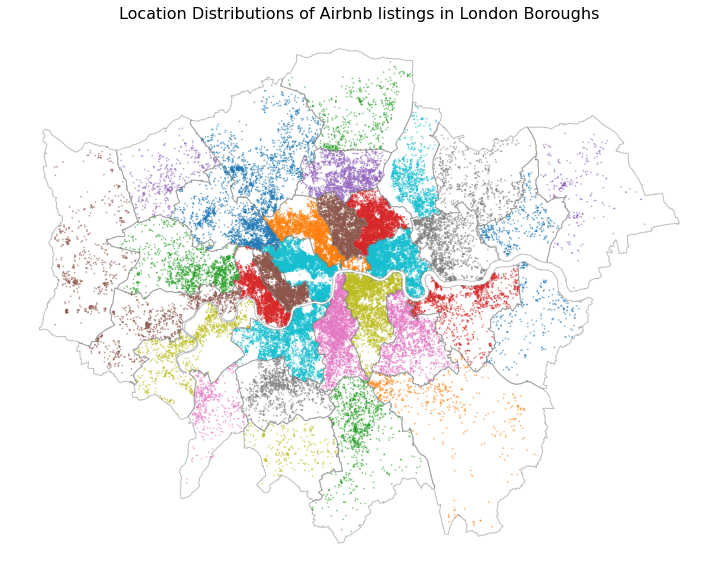

In [14]:
def airbnb_loc():
    
    ax = gdf_boros.plot(column='NAME', markersize=0.5, alpha=0.5, figsize=(16,10))
    boros.plot(ax=ax, edgecolor='0.5', facecolor='None', alpha=0.5);
    ax.axis('off')

    ax.set_title('Location Distributions of Airbnb listings in London Boroughs', fontdict={
             'fontsize': '16', 'fontweight': '1'})
    
airbnb_loc()

## 2.2 Average price of Airbnb

### Boxplot

(0.0, 500.0)

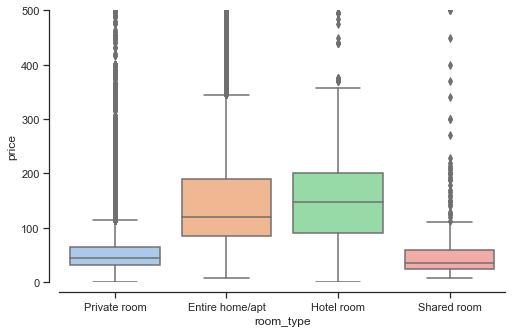

In [15]:
# boxplot based on room type of airbnb
sns.set_style('whitegrid')
sns.set_theme(style="ticks", palette="pastel")
f,ax = plt.subplots(figsize=(8,5))
sns.boxplot(y=gdf_boros.price, x=gdf_boros.room_type)
sns.despine(offset=10)
ax.set_ylim([0,500])

### Mapping

In [16]:
# set the data in one group
gdf_data = gdf_boros.groupby(['NAME'])
print(type(gdf_data))

<class 'pandas.core.groupby.generic.DataFrameGroupBy'>


In [17]:
# calculate the mean price of airbnb by borough
airbnb_price_mean = gdf_data.price.mean()
airbnb_price_mean

NAME
Barking and Dagenham       76.228205
Barnet                    132.564495
Bexley                     67.400735
Brent                     125.370545
Bromley                    79.121547
Camden                    156.061052
City of London            241.044944
Croydon                    67.545024
Ealing                     91.391746
Enfield                    72.527145
Greenwich                 136.095918
Hackney                   103.768250
Hammersmith and Fulham    141.785832
Haringey                   96.059259
Harrow                     77.497674
Havering                   83.254902
Hillingdon                 92.024348
Hounslow                  111.526795
Islington                 143.295825
Kensington and Chelsea    209.909566
Kingston upon Thames      103.535787
Lambeth                   101.165613
Lewisham                   90.135135
Merton                    121.448683
Newham                     91.285803
Redbridge                  79.078049
Richmond upon Thames      137.435

In [18]:
# merge the data
boros_airbnb_price = boros.merge(airbnb_price_mean, how = 'left', on = 'NAME')
print(boros_airbnb_price.info)

<bound method DataFrame.info of                       NAME   GSS_CODE   HECTARES  NONLD_AREA ONS_INNER  \
0     Kingston upon Thames  E09000021   3726.117       0.000         F   
1                  Croydon  E09000008   8649.441       0.000         F   
2                  Bromley  E09000006  15013.487       0.000         F   
3                 Hounslow  E09000018   5658.541      60.755         F   
4                   Ealing  E09000009   5554.428       0.000         F   
5                 Havering  E09000016  11445.735     210.763         F   
6               Hillingdon  E09000017  11570.063       0.000         F   
7                   Harrow  E09000015   5046.330       0.000         F   
8                    Brent  E09000005   4323.270       0.000         F   
9                   Barnet  E09000003   8674.837       0.000         F   
10                 Lambeth  E09000022   2724.940      43.927         T   
11               Southwark  E09000028   2991.340     105.139         T   
12    

In [19]:
boros_airbnb_price.drop(columns=['HECTARES','NONLD_AREA','ONS_INNER'], inplace=True)

<ipython-input-20-9bfccd709c5c>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = cbar.ax.set_yticklabels(bins)


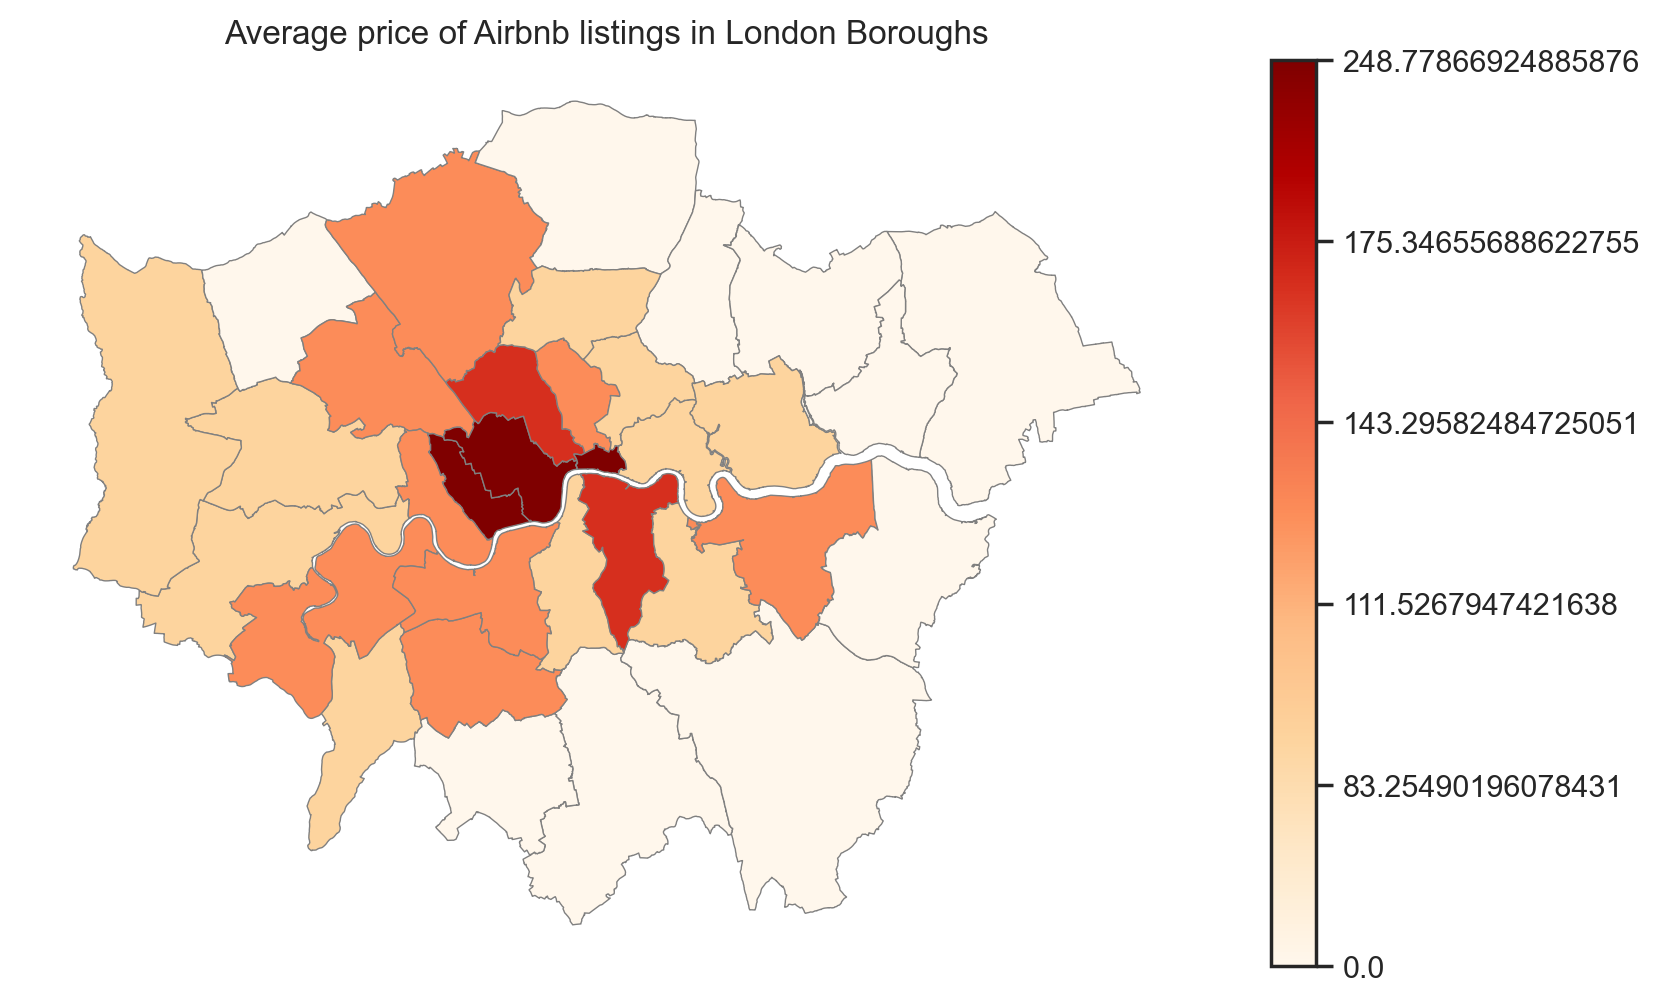

In [20]:
def airbnb_price():
    
    fig, ax = plt.subplots(1, figsize=(10, 6), dpi=200)
    
    boros_airbnb_price.plot(column='price', cmap='OrRd', scheme='FisherJenks',
                            linewidth=0.5, edgecolor='0.5', ax=ax)

    ax.axis('off')

    # Create colorbar as a legend 
    sm = plt.cm.ScalarMappable(cmap='OrRd')
    # add the colorbar to the figure 
    cbar = fig.colorbar(sm)
    bins = mapclassify.FisherJenks(boros_airbnb_price['price'], 5).bins
    bins = np.insert(bins, 0, 0)
    _ = cbar.ax.set_yticklabels(bins)

    ax.set_title('Average price of Airbnb listings in London Boroughs', fontdict={
        'fontsize': '12', 'fontweight': '1'})
    
airbnb_price()

## 2.3 Average price of Rental Market

In [21]:
# merge the data
boros_rental = pd.merge(boros, df_rental, left_on = 'NAME', right_on = 'Borough', how = 'inner')
print(boros_rental.info)

<bound method DataFrame.info of                      NAME   GSS_CODE  HECTARES  NONLD_AREA ONS_INNER  \
0    Kingston upon Thames  E09000021  3726.117       0.000         F   
1    Kingston upon Thames  E09000021  3726.117       0.000         F   
2    Kingston upon Thames  E09000021  3726.117       0.000         F   
3    Kingston upon Thames  E09000021  3726.117       0.000         F   
4    Kingston upon Thames  E09000021  3726.117       0.000         F   
..                    ...        ...       ...         ...       ...   
183  Barking and Dagenham  E09000002  3779.934     169.150         F   
184  Barking and Dagenham  E09000002  3779.934     169.150         F   
185        City of London  E09000001   314.942      24.546         T   
186        City of London  E09000001   314.942      24.546         T   
187        City of London  E09000001   314.942      24.546         T   

                                              geometry               Borough  \
0    MULTIPOLYGON (((51

In [22]:
boros_rental.drop(columns=['HECTARES','NONLD_AREA','ONS_INNER'], inplace=True)

<ipython-input-23-51783d0df3a4>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  legend = cbar.ax.set_yticklabels(bins)


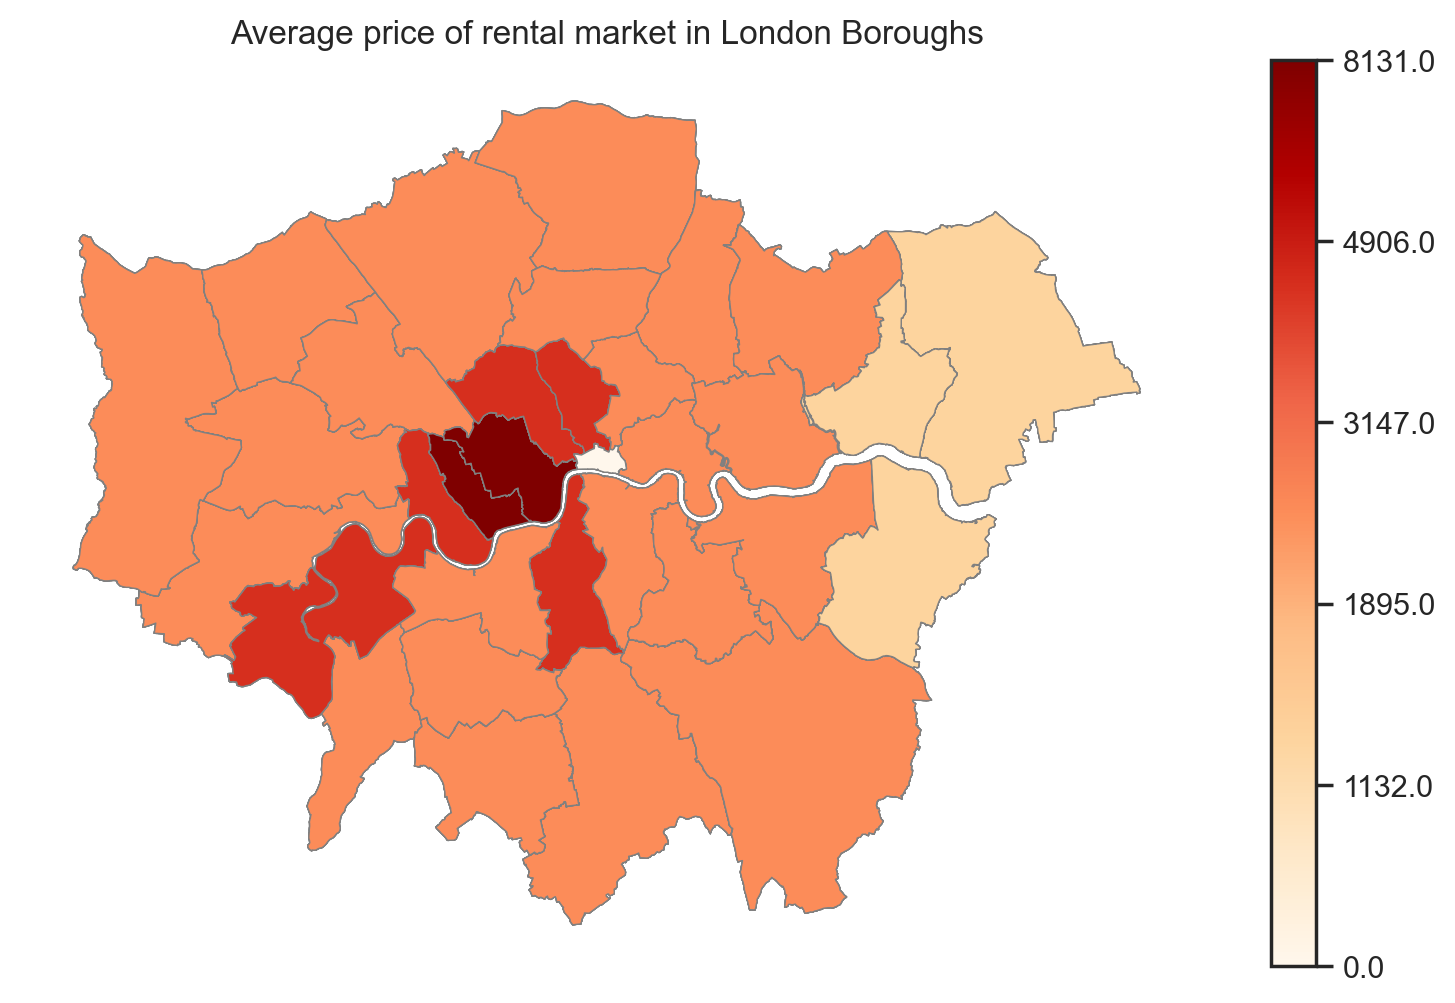

In [23]:
def rental_price():
    
    fig, ax = plt.subplots(1, figsize=(10, 6), dpi=200)

    boros_rental.plot(column='Mean', cmap='OrRd', scheme='FisherJenks',
                      linewidth=0.5, edgecolor='0.5', ax=ax)

    ax.axis('off')

    # Create colorbar as a legend 
    sm = plt.cm.ScalarMappable(cmap='OrRd')
    # add the colorbar to the figure 
    cbar = fig.colorbar(sm)
    bins = mapclassify.FisherJenks(boros_rental['Mean'], 5).bins
    bins = np.insert(bins, 0, 0)
    legend = cbar.ax.set_yticklabels(bins)

    ax.set_title('Average price of rental market in London Boroughs', fontdict={
        'fontsize': '12', 'fontweight': '1'})
    
rental_price()

# 3. Regression

In [24]:
# merge the data of rental and airbnb
boros_rental_airbnb = pd.merge(boros_rental, airbnb_price_mean, left_on = 'Borough', right_on = 'NAME', how = 'inner')
boros_rental_airbnb

,NAME,GSS_CODE,geometry,Borough,Bedroom_Category,Count_of_rents,Mean,price
0,Kingston upon Thames,E09000021,"MULTIPOLYGON (((516401.600 160201.800, 516407....",Kingston upon Thames,Room,110.0,506.0,103.535787
1,Kingston upon Thames,E09000021,"MULTIPOLYGON (((516401.600 160201.800, 516407....",Kingston upon Thames,Studio,20.0,842.0,103.535787
2,Kingston upon Thames,E09000021,"MULTIPOLYGON (((516401.600 160201.800, 516407....",Kingston upon Thames,One Bedroom,190.0,1102.0,103.535787
3,Kingston upon Thames,E09000021,"MULTIPOLYGON (((516401.600 160201.800, 516407....",Kingston upon Thames,Two Bedrooms,270.0,1374.0,103.535787
4,Kingston upon Thames,E09000021,"MULTIPOLYGON (((516401.600 160201.800, 516407....",Kingston upon Thames,Three Bedrooms,150.0,1731.0,103.535787
...,...,...,...,...,...,...,...,...
183,Barking and Dagenham,E09000002,"MULTIPOLYGON (((543905.400 183199.100, 543905....",Barking and Dagenham,Three Bedrooms,150.0,1438.0,76.228205
184,Barking and Dagenham,E09000002,"MULTIPOLYGON (((543905.400 183199.100, 543905....",Barking and Dagenham,Four or More Bedrooms,30.0,1695.0,76.228205
185,City of London,E09000001,"MULTIPOLYGON (((531145.100 180782.100, 531143....",City of London,Room,0.0,0.0,241.044944
186,City of London,E09000001,"MULTIPOLYGON (((531145.100 180782.100, 531143....",City of London,One Bedroom,10.0,2050.0,241.044944


## 3.1 Linear Regression

In [25]:
# set the average price of airbnb as x value
# set the average price of rental market as y value
x_values = boros_rental_airbnb['price']
y_values = boros_rental_airbnb['Mean']

In [26]:
x_values

0      103.535787
1      103.535787
2      103.535787
3      103.535787
4      103.535787
          ...    
183     76.228205
184     76.228205
185    241.044944
186    241.044944
187    241.044944
Name: price, Length: 188, dtype: float64

In [27]:
y_values

0       506.0
1       842.0
2      1102.0
3      1374.0
4      1731.0
        ...  
183    1438.0
184    1695.0
185       0.0
186    2050.0
187       0.0
Name: Mean, Length: 188, dtype: float64

In [28]:
import statsmodels.api as sms

X_values = sms.add_constant(x_values)
regression_model_a = sms.OLS(y_values, X_values)
regression_model_b = regression_model_a.fit()

print(regression_model_b.summary())
print()

                            OLS Regression Results                            
Dep. Variable:                   Mean   R-squared:                       0.155
Model:                            OLS   Adj. R-squared:                  0.151
Method:                 Least Squares   F-statistic:                     34.23
Date:                Sun, 09 Jan 2022   Prob (F-statistic):           2.17e-08
Time:                        17:12:10   Log-Likelihood:                -1554.7
No. Observations:                 188   AIC:                             3113.
Df Residuals:                     186   BIC:                             3120.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        534.9275    192.914      2.773      0.0

In [29]:
p_value    = regression_model_b.f_pvalue
R_squared  = regression_model_b.rsquared
print("R_squared  =", R_squared)
print("p_value    =", p_value)

R_squared  = 0.1554182305910059
p_value    = 2.171524133736069e-08


## 3.2 Log Regression

In [30]:
import statsmodels.formula.api as sm

regression_model_log = sm.ols(formula="Mean ~ price.apply(np.log)", data = boros_rental_airbnb).fit()
print(regression_model_log.params)

Intercept             -4006.316238
price.apply(np.log)    1196.846305
dtype: float64


In [31]:
print(regression_model_log.summary())

                            OLS Regression Results                            
Dep. Variable:                   Mean   R-squared:                       0.153
Model:                            OLS   Adj. R-squared:                  0.149
Method:                 Least Squares   F-statistic:                     33.73
Date:                Sun, 09 Jan 2022   Prob (F-statistic):           2.70e-08
Time:                        17:12:10   Log-Likelihood:                -1554.9
No. Observations:                 188   AIC:                             3114.
Df Residuals:                     186   BIC:                             3120.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept           -4006.3162    

In [32]:
p_value_log    = regression_model_log.f_pvalue
R_squared_log  = regression_model_log.rsquared
print("R_squared_log  =", R_squared_log)
print("p_value_log    =", p_value_log)

R_squared_log  = 0.15349360398741407
p_value_log    = 2.6992353795885254e-08
